In [1]:
!wget -O data.tgz https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz

--2021-04-17 01:46:19--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.100.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.100.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1343715595 (1.3G) [application/x-tar]
Saving to: ‘data.tgz’

data.tgz            100%[===================>]   1.25G  34.5MB/s    in 38s     

2021-04-17 01:46:57 (33.8 MB/s) - ‘data.tgz’ saved [1343715595/1343715595]



In [2]:
!tar xzf data.tgz

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import random
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler

SEED = 1337
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 256

TRAIN_DIR = 'imagewoof2/train/'
VAL_DIR  = 'imagewoof2/val/'

N_CLASSES = len(os.listdir(TRAIN_DIR))
EPOCHS = 30
ETA_MIN = 3e-6
LR = 3e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model Preparation

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=.5),
        transforms.RandomVerticalFlip(p=.5),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_ds = datasets.ImageFolder(TRAIN_DIR, data_transforms['train'])
val_ds = datasets.ImageFolder(VAL_DIR, data_transforms['val'])

train_dl = DataLoader(train_ds, TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, VAL_BATCH_SIZE, shuffle=False, num_workers=2)

In [3]:
def set_seed(seed = 42, set_torch=True):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    if set_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False 

In [4]:
class WoofNet(nn.Module):
    def __init__(self, backbone, n_classes, name='woofnet'):
        super(WoofNet, self).__init__()
        self.backbone = list(backbone.children())
        self.fc = nn.Linear(self.backbone[-1].in_features, n_classes)
        self.backbone = nn.Sequential(*self.backbone[:-1])
        self.name = name
    
    def forward(self, x):
        x = self.backbone(x).squeeze(-1).squeeze(-1)
        return self.fc(x)

In [5]:
backbone = models.resnet101(pretrained=True)
model = WoofNet(backbone, N_CLASSES, name='resnet101').to(device)

optimizer = optim.Adam(model.parameters(), LR)
loss_fn = nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=EPOCHS * len(train_dl), eta_min=ETA_MIN)

# Model training


In [6]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, scheduler, device=device, epochs=1):
    set_seed(SEED)

    start = time.time()
    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)
                dataloader = train_dl
            else:
                model.train(False)
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0
            
            for x, y in dataloader:
                x = x.to(device)
                y = y.to(device)
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()

                    outputs = model(x)
                    loss = loss_fn(outputs, y)
                    
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y)

                acc = acc_fn(outputs.detach(), y)

                running_acc  += acc.cpu().item()*dataloader.batch_size
                running_loss += loss.detach().cpu().item()*dataloader.batch_size 

                if step % 100 == 0:
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)
            
            if phase == 'valid' and valid_loss and epoch_loss < min(valid_loss):
                torch.save(model.state_dict(), 'model.bin')
            elif phase == 'valid' and not valid_loss:
                torch.save(model.state_dict(), 'model.bin')
            
            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss

def accuracy_fn(logits, y_true):
    return torch.sum((torch.argmax(logits, 1) == y_true))/y_true.shape[0]

In [7]:
tloss, vloss = train(model, train_dl, val_dl, loss_fn, optimizer, accuracy_fn, scheduler, epochs=EPOCHS)

Epoch 29/29
----------
valid Loss: 0.3020 Acc: 0.9627431868050474
----------
Training complete in 40m 5s


In [8]:
model.load_state_dict(torch.load('model.bin'))

<All keys matched successfully>

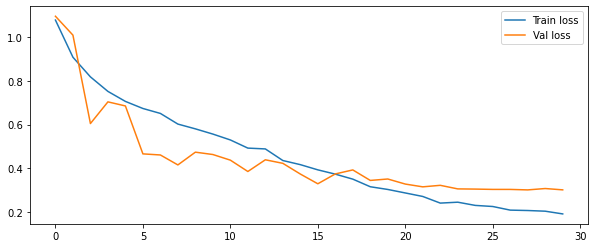

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(tloss, label='Train loss')
plt.plot(vloss, label='Val loss')
plt.legend()

# Prediction

In [67]:
import glob
from PIL import Image
filenames = glob.glob('imagewoof2/val/*/*.JPEG')

In [68]:
class TestDataset(Dataset):
    def __init__(self, filenames, transforms):
        self.transform = transforms
        self.filenames = filenames

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):        
        image = Image.open(self.filenames[index]).convert('RGB')
        image = self.transform(image)
        return torch.tensor(image, dtype=torch.float32)

In [69]:
test_ds = TestDataset(filenames, data_transforms['val'])
test_dl = DataLoader(test_ds, VAL_BATCH_SIZE, shuffle=False)

In [85]:
def predict(model, dataloader, device):
    model = model.eval()
    predictions = None
    with torch.no_grad():
        for x in dataloader:
            x = x.to(device)
            logits = model(x)
            p = torch.argmax(logits, 1).cpu().view(-1).numpy()

            if predictions is None:
                predictions = p
            else:
                predictions = np.concatenate((predictions, p), axis=0)
        return predictions

In [86]:
preds = predict(model, test_dl, device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [89]:
preds

array([4, 4, 4, ..., 9, 9, 9])